In [1]:
from matplotlib.colors import ListedColormap
from PIL import Image
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tiatoolbox.tools.patchextraction import SlidingWindowPatchExtractor
from tiatoolbox.wsicore.wsireader import WSIReader

|2025-07-23|11:00:57.091| [WARNING] /cluster/home/srivash/miniforge3/envs/tiatoolbox/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



In [5]:
import tiatoolbox
print(tiatoolbox.__version__)


1.6.0


In [2]:
import openslide; print(openslide.__version__)

1.4.2


In [4]:
data_path = '/lab/deasylab3/Jung/tiger/'
dir_TIFF_images = data_path + "/wsirois/wsi-level-annotations/images/"


imgs_names = os.listdir(dir_TIFF_images)
imgs_names.sort()

imgs_names = [i for i in imgs_names if i.startswith('TCGA')]    


In [5]:
wsi_path = dir_TIFF_images + imgs_names[2]

|2025-07-18|10:12:38.361| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


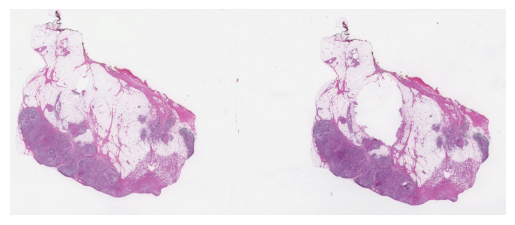

In [6]:
from tiatoolbox.tools.tissuemask import OtsuTissueMasker
from tiatoolbox.wsicore.wsireader import WSIReader
reader = WSIReader.open(wsi_path)
thumbnail = reader.slide_thumbnail(resolution=1, units="power")
plt.imshow(thumbnail)
plt.axis("off")
plt.show()

masker = OtsuTissueMasker()
tissue_masks = masker.fit_transform([thumbnail])


In [25]:
png_paths = sorted(glob.glob(os.path.join("data_loader_tiles", "*.png")))

In [76]:
wsi_path = sorted(glob.glob(os.path.join(dir_TIFF_images,"*.tif")))

In [65]:
Path(imgs_names[11])


PosixPath('TCGA-A2-A0T2-01Z-00-DX1.29A5C4C8-6AE8-44EE-98C2-ACBCBFBE9D60.tif')

In [52]:
"""Import modules required to run the Jupyter notebook."""

from __future__ import annotations

# Clear logger to use tiatoolbox.logger
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import shutil
import warnings
from pathlib import Path
from zipfile import ZipFile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, confusion_matrix

from tiatoolbox import logger
from tiatoolbox.models.engine.patch_predictor import (
    IOPatchPredictorConfig,
    PatchPredictor,
)
from tiatoolbox.utils.misc import download_data, grab_files_from_dir, imread
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

mpl.rcParams["figure.dpi"] = 160  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

In [53]:
tumour_predictor = PatchPredictor(
    pretrained_model="resnet18-idars-tumour",
    batch_size=64,
    num_loader_workers=4,
)

In [54]:
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{'units': 'mpp', 'resolution': 0.5}],
    patch_input_shape=[512, 512],
    stride_shape=[256, 256],
)

In [78]:
from pathlib import Path

tumour_output = tumour_predictor.predict(
    imgs=wsi_path,
    mode='wsi',
    return_probabilities=True,
    device="cuda",
    ioconfig=wsi_ioconfig
)


More than 1 WSIs detected but there is no save directory set.All subsequent output will be saved to current runtimelocation under folder 'output'. Overwriting may happen!


AttributeError: 'str' object has no attribute 'parent'

In [6]:

patch_size = (224, 224)
stride = (224, 224)

# 4. Create extractor
extractor = SlidingWindowPatchExtractor(
    input_img=wsi_path,
    patch_size=patch_size,
    stride=stride,
    input_mask="otsu",
    min_mask_ratio=0.5,
)

|2025-07-15|09:56:30.383| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).
|2025-07-15|09:56:30.384| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


In [7]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image

# --- Create output directory ---
output_dir = "data_loader_tiles"
os.makedirs(output_dir, exist_ok=True)

# --- Get coordinates from the patch extractor ---
coords = extractor.locations_df[["x", "y"]]

# --- Initialize metadata list ---
metadata = []

# --- Loop over patch extractor and save each patch using PIL ---
for i, patch in enumerate(tqdm(extractor)):
    # Get corresponding coordinates
    x, y = int(coords.iloc[i]["x"]), int(coords.iloc[i]["y"])
    
    # Construct filename
    filename = f"tile_{i}_{x:05d}_{y:05d}.png"
    save_path = os.path.join(output_dir, filename)
    
    # Convert patch (NumPy array) to PIL Image and save
    img = Image.fromarray(patch)
    img.save(save_path)
    
    # Add metadata
    metadata.append({
        "index": i,
        "filename": filename,
        "x": x,
        "y": y})


# --- Save metadata CSV ---
df = pd.DataFrame(metadata)
df.to_csv(os.path.join(output_dir, "data_loader_tiles.csv"), index=False)



00%|██████████| 26133/26133 [22:57<00:00, 18.97it/s]

In [8]:
df.to_csv(os.path.join(output_dir, "tile_metadata.csv"), index=False)

In [2]:
# Clear logger to use tiatoolbox.logger
import logging
import warnings

import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from tiatoolbox import logger
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor
from tiatoolbox.utils.misc import download_data, imread

# We need this function to visualize the nuclear predictions
from tiatoolbox.utils.visualization import (
    overlay_prediction_contours,
)
from tiatoolbox.wsicore.wsireader import WSIReader

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore")
mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
plt.rcParams.update({"font.size": 5})
import glob
# cell segmentation 
inst_segmentor = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke",
    num_loader_workers=2,
    num_postproc_workers=2,
    batch_size=4,
)

In [3]:
png_paths = sorted(glob.glob(os.path.join("data_loader_tiles", "*.png")))

In [4]:
len(png_paths)


26133

In [ ]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


tile_output = inst_segmentor.predict(
    png_paths,
    save_dir=f"instance_segmentation_tiles_{timestamp}",
    mode="tile",
    device="cpu",
    crash_on_exception=False,
)


WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
Raw data is None.
Unknown scale (no objective_power or mpp)
Raw data is None.
W0715 11:17:10.006000 4143921 site-packages/torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward /cluster/home/srivash/miniforge3/envs/tiatoolbox-gpu/lib/python3.10/site-packages/tiatoolbox/models/architecture/hovernet.py line 398 
W0715 11:17:10.006000 4143921 site-packages/torch/_dynamo/convert_frame.py:1125] due to: 
W0715 11:17:10.006000 4143921 site-packages/torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W0715 11:17:10.006000 4143921 site-packages/torch/_dynamo/convert_frame.py:1125]   File "/cluster/home/srivash/miniforge3/envs/tiatoolbox-gpu/lib/python3.10/site-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W0715 11:17:10.006000

In [5]:
import os

dat_folder = "instance_segmentation_tiles_20250715_111658"

# List all .dat files not starting with 'file'
dat_files = [
    f for f in os.listdir(dat_folder)
    if f.endswith(".dat") and not f.startswith("file")
]


In [6]:
import os
import joblib
import pandas as pd

# Folder path
dat_folder = "instance_segmentation_tiles_20250715_111658"

# Get all .dat files excluding those starting with "file"
dat_files = [
    os.path.join(dat_folder, f)
    for f in os.listdir(dat_folder)
    if f.endswith(".dat") and not f.startswith("file")]

# Mapping of type labels
type_mapping = {
    0: "background",
    1: "Tumor",
    2: "Inflammatory",
    3: "Connective",
    4: "Dead",
    5: "non-neoplastic epithelial"
}

# Master list to collect all nuclei data
Master_nuclei_data = []

# Loop over each valid .dat file
for data in dat_files:
    file_number = os.path.splitext(os.path.basename(data))[0]  # e.g., '555'

    try:
        tile_preds = joblib.load(data)
    except Exception as e:
        print(f"Failed to load {data}: {e}")
        continue

    for nuc_id, sample_nuc in tile_preds.items():
        cell_type_id = sample_nuc.get("type")
        cell_type_name = type_mapping.get(cell_type_id, "Unknown")

        #bounding_box = sample_nuc.get("box", [None, None, None, None])
        #centroid = sample_nuc.get("centroid", [None, None])
        probability = sample_nuc.get("prob")

        # Convert contour to plain list of [x, y]
        #raw_contour = sample_nuc.get("contour", [])
        #contour = [list(point) for point in raw_contour]  # Ensure it's JSON/CSV serializable

        Master_nuclei_data.append({
            "file_number": file_number,
            "nuc_id": nuc_id,
            "type": cell_type_id,
            "type_name": cell_type_name,
           #"bounding_box": bounding_box,
            #"centroid": centroid,
            "prob": probability,
            #"contour": contour
        })

# Convert to DataFrame
df = pd.DataFrame(Master_nuclei_data)

# Optional: Save to CSV (convert contour to string format for CSV)
#

# Display result
print(f"Total nuclei processed: {len(df)}")
print(df.head())


tumor_immune_df = df
files_with_tumor_or_immune = tumor_immune_df['file_number'].unique()
print("File numbers with Tumor or Immune cells:")
print(files_with_tumor_or_immune)

type_counts = tumor_immune_df['type_name'].value_counts()
print("\nTotal count of Tumor and Immune nuclei:")
print(type_counts)

count_per_file = tumor_immune_df.groupby(['file_number', 'type_name']).size().reset_index(name='count')
print("\nCount of Tumor and Immune nuclei per file_number:")
print(count_per_file)


Total nuclei processed: 748205
  file_number                            nuc_id  type type_name      prob
0           1  527570ed845b48c4948b0cd1523fd56c     4      Dead  1.000000
1           1  f76a562d09404f5a847c23865030bdee     4      Dead  1.000000
2           1  ef3fadfa76134e379e45b0e6621e5809     4      Dead  0.983146
3           1  bdf0d659a4204509815ba71c99ac70cd     4      Dead  0.956522
4           1  d1d1ad9b930a4c4faf57a5789da32891     4      Dead  1.000000
File numbers with Tumor or Immune cells:
['1' '2' '3' ... '26130' '26131' '26132']

Total count of Tumor and Immune nuclei:
type_name
Tumor                        451725
Dead                         132871
Connective                    95838
Inflammatory                  38915
non-neoplastic epithelial     19359
background                     9497
Name: count, dtype: int64

Count of Tumor and Immune nuclei per file_number:
      file_number     type_name  count
0               1          Dead     58
1               1   

In [8]:
file_number

'26132'

In [55]:
# Pivot to get counts of each type_name as columns per file_number
count_pivot = count_per_file.pivot(index='file_number', columns='type_name', values='count').fillna(0)

# Calculate total nuclei per file_number
count_pivot['total'] = count_pivot.sum(axis=1)

# Calculate percentage per type
percentage_df = count_pivot.div(count_pivot['total'], axis=0) * 100

# Drop the total column if you only want percentages
percentage_df = percentage_df.drop(columns=['total'])

# Reset index to match format of count_per_file
percentage_df = percentage_df.reset_index()

# Display result
print("\nPercentage of each cell type per file:")
print(percentage_df)



Percentage of each cell type per file:
type_name file_number  Connective       Dead  Inflammatory       Tumor  \
0                   1    0.000000  98.305085           0.0    0.000000   
1                  10    0.000000  19.047619           0.0   80.952381   
2                 100    0.000000   0.000000           0.0  100.000000   
3                1000    2.439024  19.512195           0.0   78.048780   
4               10000  100.000000   0.000000           0.0    0.000000   
...               ...         ...        ...           ...         ...   
25640            9993   50.000000   0.000000          50.0    0.000000   
25641            9995  100.000000   0.000000           0.0    0.000000   
25642            9996   75.000000   0.000000          25.0    0.000000   
25643            9997    0.000000   0.000000           0.0  100.000000   
25644            9998    2.564103   5.128205           0.0   92.307692   

type_name  background  non-neoplastic epithelial  
0            1.69491

In [9]:
df.to_csv("data_loader_percentage_df.csv", index=False)

In [54]:

tumor_immune_df = df
files_with_tumor_or_immune = tumor_immune_df['file_number'].unique()
print("File numbers with Tumor or Immune cells:")
print(files_with_tumor_or_immune)

type_counts = tumor_immune_df['type_name'].value_counts()
print("\nTotal count of Tumor and Immune nuclei:")
print(type_counts)

count_per_file = tumor_immune_df.groupby(['file_number', 'type_name']).size().reset_index(name='count')
print("\nCount of Tumor and Immune nuclei per file_number:")
print(count_per_file)


File numbers with Tumor or Immune cells:
['1' '2' '3' ... '26130' '26131' '26132']

Total count of Tumor and Immune nuclei:
type_name
Tumor                        451725
Dead                         132871
Connective                    95838
Inflammatory                  38915
non-neoplastic epithelial     19359
background                     9497
Name: count, dtype: int64

Count of Tumor and Immune nuclei per file_number:
      file_number     type_name  count
0               1          Dead     58
1               1    background      1
2              10          Dead      8
3              10         Tumor     34
4             100         Tumor     38
...           ...           ...    ...
77697        9996  Inflammatory      1
77698        9997         Tumor     24
77699        9998    Connective      1
77700        9998          Dead      2
77701        9998         Tumor     36

[77702 rows x 3 columns]


In [7]:
count_per_file.to_csv("tile_identifier_data.csv", index=False)

In [48]:

# Load the two CSVs
df1 = pd.read_csv("tile_identifier_data.csv")  # Replace with your actual path
df2 = pd.read_csv("data_loader_tiles.csv")  # Replace with your actual path

# Merge on file_number
metadata_df = pd.merge(df1, df2, on='file_number', how='inner')

# Optional: inspect or save
print("Merged Metadata:")
print(metadata_df.head())




Merged Metadata:
   file_number   type_name  count                  filename      x     y
0            1  Background      1    tile_1_44576_00448.png  44576   448
1            1  Connective     58    tile_1_44576_00448.png  44576   448
2           10  Connective      8   tile_10_36960_02240.png  36960  2240
3           10       Tumor     34   tile_10_36960_02240.png  36960  2240
4          100       Tumor     38  tile_100_13440_04256.png  13440  4256


In [49]:
metadata_df["roi"] = np.where(
    (metadata_df["type_name"].isin(['Tumor', 'Immune'])) & (metadata_df["count"] > 20),
    1,
    0)


In [50]:
metadata_df

,file_number,type_name,count,filename,x,y,roi
0,1,Background,1,tile_1_44576_00448.png,44576,448,0
1,1,Connective,58,tile_1_44576_00448.png,44576,448,0
2,10,Connective,8,tile_10_36960_02240.png,36960,2240,0
3,10,Tumor,34,tile_10_36960_02240.png,36960,2240,1
4,100,Tumor,38,tile_100_13440_04256.png,13440,4256,1
...,...,...,...,...,...,...,...
77697,9996,Inflammatory,3,tile_9996_11872_17696.png,11872,17696,0
77698,9997,Tumor,24,tile_9997_12096_17696.png,12096,17696,1
77699,9998,Connective,2,tile_9998_12320_17696.png,12320,17696,0
77700,9998,Inflammatory,1,tile_9998_12320_17696.png,12320,17696,0


In [51]:
metadata_df.to_csv("data_loader_tiles_metadata.csv", index = False)